In [1]:
from speechbrain.inference.ASR import EncoderASR
import pyaudio
import numpy as np
import wave
import os
import noisereduce as nr
import matplotlib.pyplot as plt
import keyboard
from IPython.display import Audio, display
import time

c:\Users\Mussa\.conda\envs\ml_env_38\lib\inspect.py:745: UserWarning: Module 'speechbrain.pretrained' was deprecated, redirecting to 'speechbrain.inference'. Please update your script. This is a change from SpeechBrain 1.0. See: https://github.com/speechbrain/speechbrain/releases/tag/v1.0.0
  if ismodule(module) and hasattr(module, '__file__'):


In [2]:
# define automatic speech recognition model

asr_model = EncoderASR.from_hparams(
  source="speechbrain/asr-wav2vec2-dvoice-swahili",
  savedir="pretrained_models/asr-wav2vec2-dvoice-swahili"
)


speechbrain.lobes.models.huggingface_transformers.huggingface - Wav2Vec2Model is frozen.
c:\Users\Mussa\.conda\envs\ml_env_38\lib\site-packages\speechbrain\utils\checkpoints.py:194: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub 

In [3]:
word = 'word'
output_dir = 'input_audios' + '/' + word
os.makedirs(output_dir, exist_ok=True)

# Get current time in milliseconds (since epoch)
# current_time_ms = str(int(time.time() * 1000))
current_time_ms = '0'

# Define the output file path
output_file = os.path.join(output_dir, current_time_ms + '-og.wav')

In [4]:
# List available input audio devices and their names
p = pyaudio.PyAudio()
print('Available input devices:')
for i in range(p.get_device_count()):
    device_info = p.get_device_info_by_index(i)
    print(f'{i}: {device_info["name"]}')

# Select the desired input device by its ID (replace with the appropriate ID)
selected_device_id = 1  # Change this to the ID of your desired input device

# Record audio from the selected input device
print(f'Recording audio will use device: "{p.get_device_info_by_index(selected_device_id)["name"]}"')

Available input devices:
0: Microsoft Sound Mapper - Input
1: Microphone (Realtek High Defini
2: Mic in at front panel (black) (
3: Stereo Mix (Realtek High Defini
4: Microsoft Sound Mapper - Output
5: Speaker/Headphone (Realtek High
6: Microphone (Realtek HD Audio Mic input)
7: Speakers (Realtek HD Audio output)
8: Mic in at front panel (black) (Mic in at front panel (black))
9: Stereo Mix (Realtek HD Audio Stereo input)
Recording audio will use device: "Microphone (Realtek High Defini"


In [39]:
# Function to start recording
def start_recording():
    global recording
    recording = True
    print('Recording audio. Press the space key to stop...')

# Function to stop recording
def stop_recording():
    global recording
    recording = False
    print('Recording stopped.')

# Function to reduce noise from audio
def reduce_noise(audio_data, sample_rate):
    # Apply noise reduction using the noisereduce library
    reduced_audio = nr.reduce_noise(y=audio_data, sr=sample_rate)
    return reduced_audio

# Set the parameters for audio recording
sample_rate = 16000  # You can adjust this based on your needs
duration = 10  # Maximum recording duration in seconds

# Initialize recording status
recording = False
audio = []

# Callback function for audio recording
def audio_callback(in_data, frame_count, time_info, status):
    if recording:
        audio.append(in_data)
    return (in_data, pyaudio.paContinue)

# Initialize PyAudio
p = pyaudio.PyAudio()

# Open an audio stream for recording
stream = p.open(format=pyaudio.paInt16,
                channels=1,
                rate=sample_rate,
                input=True,
                input_device_index=selected_device_id,
                frames_per_buffer=1024,
                stream_callback=audio_callback)

# Wait for the space key to start recording
print('Press the space key to start recording...')
keyboard.wait('space')
start_recording()

# Wait for the space key to stop recording
print('Recording audio. Press the space key to stop...')
keyboard.wait('space')
stop_recording()

# Close the audio stream
stream.stop_stream()
stream.close()
p.terminate()

Press the space key to start recording...
Recording audio. Press the space key to stop...
Recording audio. Press the space key to stop...
Recording stopped.


In [40]:
# Save the recorded audio as a WAV file
if audio:
    audio_data = b''.join(audio)
    with wave.open(output_file, 'wb') as wf:
        wf.setnchannels(1)  # Mono audio
        wf.setsampwidth(p.get_sample_size(pyaudio.paInt16))
        wf.setframerate(sample_rate)
        wf.writeframes(audio_data)

    print(f'Audio saved as {output_file}')
else:
    print('No audio recorded.')

# Reduce noise from the recorded audio
if os.path.exists(output_file):
    with wave.open(output_file, 'rb') as wf:
        audio_data = wf.readframes(-1)
        audio_data = np.frombuffer(audio_data, dtype=np.int16)
        sample_rate = wf.getframerate()
    
    # Reduce noise from the recorded audio
    reduced_audio = reduce_noise(audio_data, sample_rate)
    
    # Save the reduced audio
    reduced_output_file = os.path.join(output_dir, current_time_ms + '-clean.wav')
    with wave.open(reduced_output_file, 'wb') as wf:
        wf.setnchannels(1)  # Mono audio
        wf.setsampwidth(p.get_sample_size(pyaudio.paInt16))
        wf.setframerate(sample_rate)
        wf.writeframes(reduced_audio.tobytes())
    
    print(f'Noise reduced audio saved as {reduced_output_file}')

Audio saved as input_audios/word\0-og.wav
Noise reduced audio saved as input_audios/word\0-clean.wav


Numerical representation of the recorded audio:
[-3 -4 -6 ...  4  0 -2]


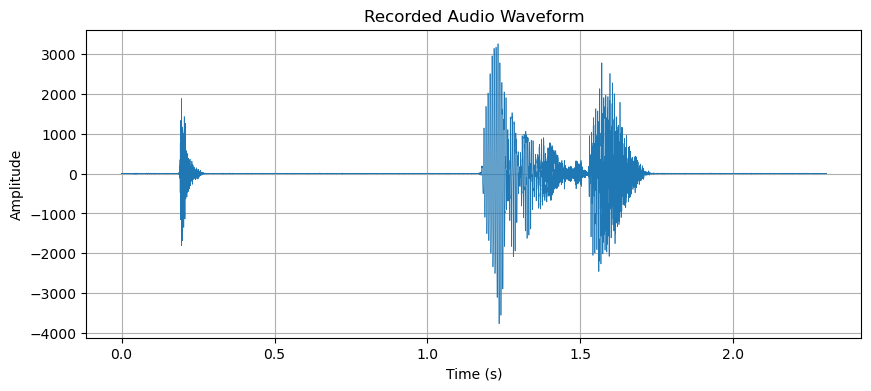

Numerical representation of the reduced audio:
[0 0 0 ... 0 0 0]


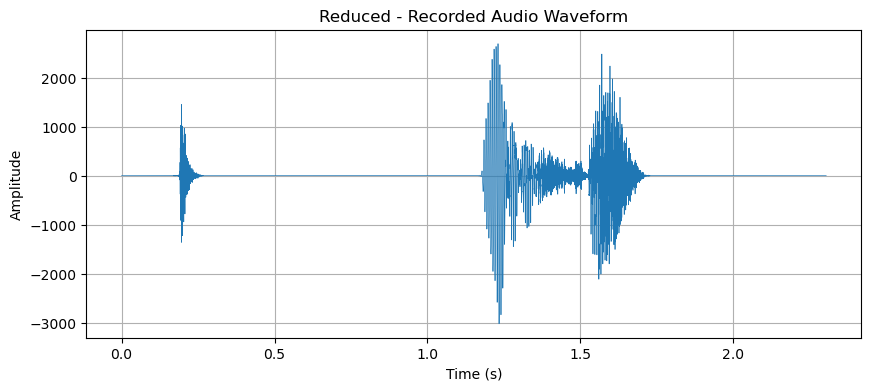

In [41]:
# Load the recorded audio file
audio_file = output_dir + '/' + current_time_ms + '-og.wav'

# Load the reduced audio file
reduced_audio_file = output_dir + '/' + current_time_ms + '-clean.wav'

# Open the audio file if exist
if os.path.exists(output_file):
    with wave.open(audio_file, 'rb') as wf:
        # Get audio data
        audio_data = wf.readframes(-1)
        audio_data = np.frombuffer(audio_data, dtype=np.int16)

        # Get sample rate and duration
        sample_rate = wf.getframerate()
        duration = len(audio_data) / sample_rate

    # Create a time array for x-axis (in seconds)
    time = np.linspace(0, duration, len(audio_data))

    # # Adjust NumPy print options to display the full array without truncation
    # np.set_printoptions(threshold=np.inf)

    # Print the numerical representation of the audio
    print('Numerical representation of the recorded audio:')
    print(audio_data)

    # Plot the audio waveform
    plt.figure(figsize=(10, 4))
    plt.plot(time, audio_data, lw=0.5)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('Recorded Audio Waveform')
    plt.grid(True)
    plt.show()

    # Play the recorded audio in the notebook
    display(Audio(filename=output_file))

# Open the reduced audio file if exist
if os.path.exists(reduced_output_file):
    with wave.open(reduced_output_file, 'rb') as wf:
        # Get audio data
        audio_data = wf.readframes(-1)
        audio_data = np.frombuffer(audio_data, dtype=np.int16)

        # Get sample rate and duration
        sample_rate = wf.getframerate()
        duration = len(audio_data) / sample_rate

    # Create a time array for x-axis (in seconds)
    time = np.linspace(0, duration, len(audio_data))
    
    # # Adjust NumPy print options to display the full array without truncation
    # np.set_printoptions(threshold=np.inf)

    # Print the numerical representation of the audio
    print('Numerical representation of the reduced audio:')
    print(audio_data)

    # Plot the audio waveform
    plt.figure(figsize=(10, 4))
    plt.plot(time, audio_data, lw=0.5)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('Reduced - Recorded Audio Waveform')
    plt.grid(True)
    plt.show()

    # # Plot the spectrogram of the reduced audio
    # plt.figure(figsize=(10, 6))
    # plt.specgram(reduced_audio, Fs=sample_rate, cmap='viridis')
    # plt.xlabel('Time (s)')
    # plt.ylabel('Frequency (Hz)')
    # plt.title('Spectrogram of Noise-Reduced Audio')
    # plt.colorbar(label='Intensity (dB)')
    # plt.show()

    # Play the recorded audio in the notebook
    display(Audio(filename=reduced_output_file))

In [43]:
# Try to recognize the word by using asr_model

asr_model.transcribe_file(
  reduced_audio_file
)

'musa '